In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
import pandas as pd
import numpy as np
from imvc.datasets import LoadDataset
from imvc.ampute import Amputer
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
from time import perf_counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from tueplots import axes, bundles
plt.rcParams.update({**bundles.icml2022(), **axes.lines()})

In [13]:
def dataset_engine_comp(results_dict, Xs, y, n_clusters, estimator, engines, ps, n_times):
    for p in ps:
        missing_percentge = int(p*100)
        results_dict[missing_percentge] = {}
        matrices_comp = {}
        amputed_Xs = Amputer(p=p, mechanism="mcar", random_state=42).fit_transform(Xs)
        for engine in engines:
            results_dict[missing_percentge][engine] = {}
            matrices_comp[engine] = []
            for i in range(n_times):
                results_dict[missing_percentge][engine][i] = {}
                estimator.set_params(n_clusters=n_clusters, engine=engine, random_state=i)
                start_time = perf_counter()
                try:
                    labels = estimator.fit_predict(amputed_Xs)
                except Exception as ex:
                    print(ex)
                    continue
                results_dict[missing_percentge][engine][i]["Computing time"] = perf_counter() - start_time
                results_dict[missing_percentge][engine][i]["AMI"] = adjusted_mutual_info_score(labels_true=y, labels_pred=labels)
                results_dict[missing_percentge][engine][i]["ARI"] = adjusted_rand_score(labels_true=y, labels_pred=labels)
                try:
                    embeddings = True
                    matrices_comp[engine].append(estimator.embedding_)
                except:
                    pass
        if embeddings:
            results_dict[missing_percentge]["both"] = {}
            results_dict[missing_percentge]["both"][0] = {}
            for engine in engines + ["both"]: 
                results_dict[missing_percentge][engine][0]["RMSE"] = []
                results_dict[missing_percentge][engine][0]["MAE"] = []
                if engine == "both":
                    mats = [mat for mats in matrices_comp.values() for mat in mats]
                else:
                    mats = matrices_comp[engine]
                combs = set(itertools.combinations(range(len(mats)), 2))
                combs = [(mats[comb[0]], mats[comb[1]]) for comb in combs]
                for i, (mat1, mat2) in enumerate(combs):
                    results_dict[missing_percentge][engine][0]["RMSE"].append(mean_squared_error(y_true=mat1, y_pred=mat2, squared=False))
                    results_dict[missing_percentge][engine][0]["MAE"].append(mean_absolute_error(y_true=mat1, y_pred=mat2))
    return results_dict

In [14]:
def engine_comp(datasets, estimator, engines, ps, n_times):
    results = {}
    for dataset in tqdm(datasets):
        names = dataset.split("_")
        if "simulated" in names:
            names = ["_".join(names)]
        x_name,y_name = names if len(names) > 1 else (names[0], "0")
        Xs, y = LoadDataset.load_dataset(dataset_name=x_name, return_y=True)
        y = y[y_name]
        n_clusters = int(y.nunique())
        
        results[dataset] = {}
        results[dataset] = dataset_engine_comp(results_dict= results[dataset], Xs=Xs, y=y, n_clusters=n_clusters,
                                      estimator=estimator, engines=engines, ps=ps, n_times=n_times)

    return results

In [ ]:
results = engine_comp(datasets= ["nutrimouse_genotype", "buaa", "bdgp", "bbcsport", "sensIT300"],
                      estimator=estimator, engines= ["python", "matlab"], ps= np.arange(0., 0.7, 0.2), n_times = 50)

In [15]:
from imvc.cluster import DAIMC
estimator_name = "DAIMC"
estimator = DAIMC()
results = engine_comp(datasets= ["nutrimouse_genotype", "buaa", "bdgp", "bbcsport", "sensIT300"],
                      estimator=estimator, engines= ["python", "matlab"], ps= np.arange(0., 0.7, 0.2), n_times = 50)

  0%|          | 0/5 [00:00<?, ?it/s]

    newinit at line 41 column 10
    _pyeval at line 57 column 30



In [16]:
flattened_data = [
    {
        'Dataset': dataset,
        'Incomplete samples (\%)': p,
        'Engine': engine,
        'Iteration': i,
        **iter_dict
    }
    for dataset, dataset_dict in results.items()
    for p, p_dict in dataset_dict.items()
    for engine, engine_dict in p_dict.items()
    for i, iter_dict in engine_dict.items()
]
results = pd.DataFrame(flattened_data)
results.to_csv(f"tutorials/engine_comparison_{estimator_name}.csv", index= None)
print("results", results.shape)
results.head()

results (2020, 9)


,Dataset,Incomplete samples (\%),Engine,Iteration,Computing time,AMI,ARI,RMSE,MAE
0,nutrimouse_genotype,0,python,0,1.122940,-0.02313,-0.016684,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,nutrimouse_genotype,0,python,1,0.904140,-0.02313,-0.016684,NaN,NaN
2,nutrimouse_genotype,0,python,2,1.027250,-0.02313,-0.016684,NaN,NaN
3,nutrimouse_genotype,0,python,3,0.381988,-0.02313,-0.016684,NaN,NaN
4,nutrimouse_genotype,0,python,4,0.247131,-0.02313,-0.016684,NaN,NaN


In [23]:
results = pd.read_csv(f"tutorials/engine_comparison_{estimator_name}.csv")
results["Engine"] = results["Engine"].replace({"python": "Python", "matlab": "Matlab", "both": "Both"})
results.head()

,Dataset,Incomplete samples (\%),Engine,Iteration,Computing time,AMI,ARI,RMSE,MAE
0,nutrimouse_genotype,0,Python,0,1.122940,-0.02313,-0.016684,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,nutrimouse_genotype,0,Python,1,0.904140,-0.02313,-0.016684,NaN,NaN
2,nutrimouse_genotype,0,Python,2,1.027250,-0.02313,-0.016684,NaN,NaN
3,nutrimouse_genotype,0,Python,3,0.381988,-0.02313,-0.016684,NaN,NaN
4,nutrimouse_genotype,0,Python,4,0.247131,-0.02313,-0.016684,NaN,NaN


In [24]:
time_engine = results.dropna().groupby(["Dataset", "Incomplete samples (\%)", "Engine"], as_index=False)["Computing time"].mean().set_index(["Dataset", "Incomplete samples (\%)"])
time_engine = time_engine.pivot(columns="Engine")
time_engine.columns = time_engine.columns.droplevel(0)
time_engine.columns.name = None
time_engine["Speed-up"] = time_engine["Matlab"] / time_engine["Python"]
time_engine = time_engine.round(1)
time_engine

Matlab  Python  Speed-up
Dataset             Incomplete samples (\%)                          
bbcsport            0                          38.8   103.0       0.4
                    20                         67.0   195.8       0.3
                    40                         75.1   183.6       0.4
                    60                         74.4   192.8       0.4
bdgp                0                          20.7    38.4       0.5
                    20                         21.9    48.8       0.4
                    40                         29.9    42.7       0.7
                    60                         25.2    69.1       0.4
buaa                0                           0.6     1.1       0.5
                    20                          0.7     0.6       1.2
                    40                          0.6     0.9       0.6
                    60                          0.6     0.9       0.6
nutrimouse_genotype 0                           0.4     1.1       0.3
                    20                          0.3     0.2       1.4
                    40                          0.2     0.3       0.8
                    60                          0.2     0.3       0.6
sensIT300           0                           0.3     2.4       0.1
                    20                          0.4     2.3       0.2
                    40                          0.4     2.0       0.2
                    60                          0.3     2.5       0.1

In [25]:
results.loc[results["Iteration"] == 0, "RMSE"] = results.loc[results["Iteration"] == 0, "RMSE"].apply(eval)
results.loc[results["Iteration"] == 0, "MAE"] = results.loc[results["Iteration"] == 0, "MAE"].apply(eval)

stability_results = []
for _, row in results[results["Iteration"] == 0].iterrows():
    for rmse, mae in zip(row["RMSE"], row["MAE"]):
        stability_results.append([row["Dataset"], row["Engine"], row["Incomplete samples (\%)"], rmse, mae])

stability_results = pd.DataFrame(stability_results, columns= ["Dataset", "Engine", "Incomplete samples (\%)", "RMSE", "MAE"])

results = results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"]).drop(columns= ["Iteration", "Computing time", "RMSE", "MAE"])
stability_results = stability_results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"])
results = results.join(stability_results, how="right").reset_index()
results = results.melt(id_vars= ["Dataset", "Engine", "Incomplete samples (\%)"], var_name='Metric', value_name='Value')
results = results.sort_values(["Dataset", "Engine", "Incomplete samples (\%)"], ascending=[True, False, True])

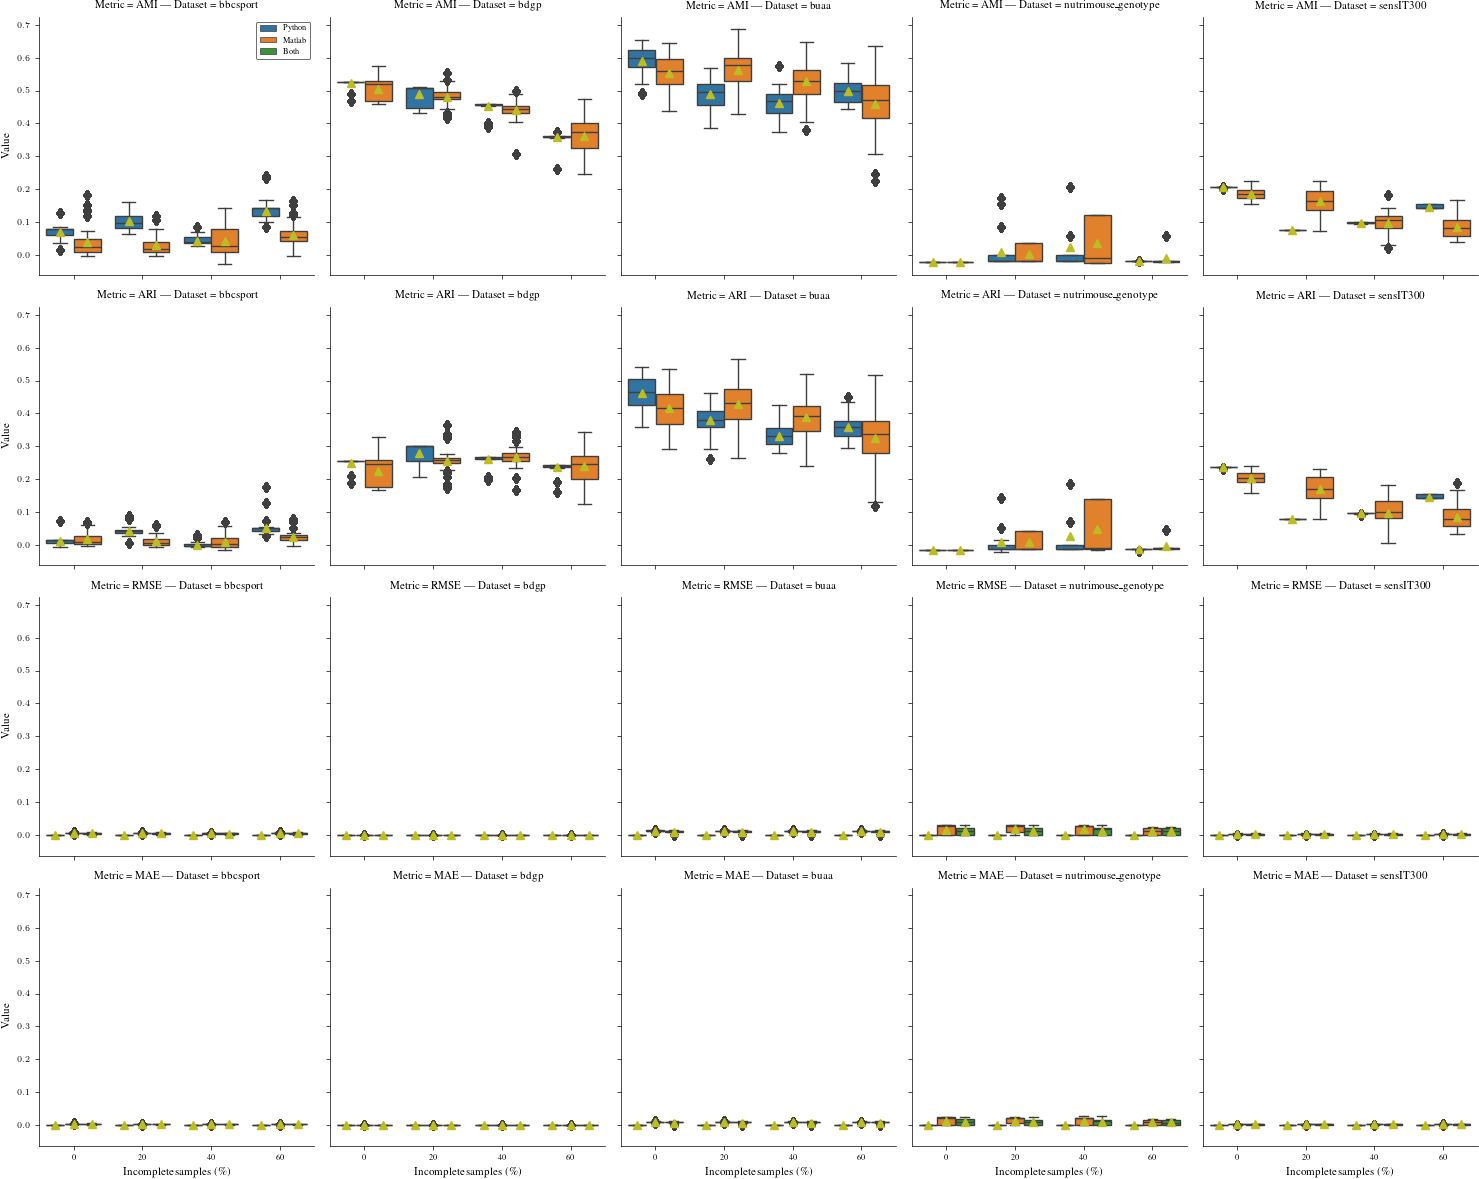

In [31]:
ax = sns.FacetGrid(data=results, row="Metric", col= "Dataset", dropna=True, legend_out=False, sharey=True).map_dataframe(
    sns.boxplot, x="Incomplete samples (\%)", y= "Value", hue= "Engine", palette= "tab10", showmeans=True,
    meanprops={'markerfacecolor':'tab:olive', 'markeredgecolor':'tab:olive'})
ax.add_legend()
plt.savefig(f"engine_comparison_{estimator_name}.pdf")